# **REINFORCE**

# Install & Import Requirements



In [1]:
!pip install swig
!pip install gymnasium[box2d]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from torch.optim import Adam
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Sequence
from tqdm import tqdm

/home/lamberto/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Helper functions

## MLP function to create the policy network of our agent

In [3]:
def mlp(sizes: Sequence[int], activation=nn.ReLU, output_activation=nn.Identity) -> nn.Sequential:
  """
  Create a simple feedforward neural network.
  """
  layers = []
  for j in range(len(sizes)-1):
    act = activation if j < len(sizes)-2 else output_activation
    layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
  return nn.Sequential(*layers)

## Functions to get the ouput of the policy network

In [4]:
def get_policy(obs: torch.Tensor) -> Normal:
  """
  Get the stochastic policy for a given observation (-batch).
  Returns a distribution for every action.
  """
  obs = obs.unsqueeze(0) if obs.dim() == 1 else obs  # for single observations that do not have a batch dimension
  logits = policy_net(obs)
  mean, logstd = logits[:, :n_acts], logits[:, n_acts:]  # split the output layer into mean and logstd
  logstd = torch.clamp(logstd, min=-20, max=2)  # for numerical stability
  return Normal(mean, torch.exp(logstd))

In [5]:
def get_action(obs: torch.Tensor) -> np.ndarray:
  """
  Get the action for a given observation.
  """
  dist = get_policy(obs)
  return dist.sample().squeeze(0).numpy()

## Function to compute the loss

In [6]:
def compute_loss(obs: torch.Tensor, act: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
  """
  Compute the REINFORCE loss for a given batch.
  """
  dist = get_policy(obs)
  logp = dist.log_prob(act).sum(dim=-1)
  return -(logp * weights).mean()

## Function to compute the discounted return

In [7]:
def discounted_return(arr: Sequence[float]) -> list[float]:
  """
  Compute the discounted return for a single episode, given a sequence of rewards.
  """
  ret = [0.0] * len(arr)
  ret[-1] = arr[-1]
  for i in range(len(arr)-2, -1, -1):
    ret[i] = arr[i] + gamma * ret[i+1]
  return ret

## Function to train one epoch

In [ ]:
def train_one_epoch() -> tuple[list, list]:
  """
  Train the policy for one epoch i.e. one update.
  """
  batch_obs = []
  batch_acts = []
  batch_weights = []
  batch_rets = []
  batch_lens = []

  obs, _ = env.reset()
  ep_rews = []
  while True:
    act = get_action(torch.as_tensor(obs, dtype=torch.float32))
    next_obs, rew, terminated, truncated, _ = env.step(act)  # the environment will automatically clip the action to [-1,1]

    batch_obs.append(obs.copy())  # copy as obs is modified in-place
    batch_acts.append(act)  # act is newly initialized every loop -> no copy
    ep_rews.append(rew)
    obs = next_obs
    done = terminated or truncated

    if done:
      ep_ret, ep_len = sum(ep_rews), len(ep_rews)
      batch_rets.append(ep_ret)
      batch_lens.append(ep_len)

      batch_weights += discounted_return(ep_rews)

      obs, _ = env.reset()
      ep_rews = []

      if len(batch_obs) > batch_size:
        break

  # convert lists to tensors
  batch_obs = torch.as_tensor(np.array(batch_obs), dtype=torch.float32)
  batch_acts = torch.as_tensor(np.array(batch_acts), dtype=torch.float32)
  batch_weights = torch.as_tensor(np.array(batch_weights), dtype=torch.float32)
  batch_weights = (batch_weights - batch_weights.mean()) / (batch_weights.std() + 1e-8).detach()

  optimizer.zero_grad()
  loss = compute_loss(batch_obs, batch_acts, batch_weights)
  loss.backward()
  optimizer.step()

  return batch_rets, batch_lens

# Train an Agent


  0%|          | 0/1000 [00:00<?, ?it/s]/home/lamberto/.local/lib/python3.10/site-packages/torch/autograd/graph.py:824: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 1000/1000 [25:59<00:00,  1.56s/it, avg_ret=223, avg_len=330]


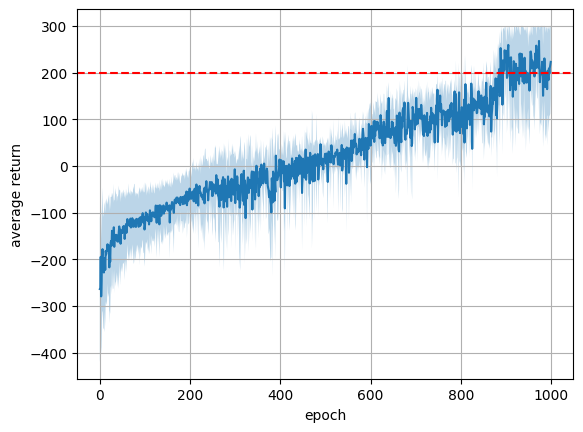

In [9]:

env_name="LunarLander-v3"
hidden_sizes=[64,64]
lr=3e-4
epochs=1_000
batch_size=5_000
gamma=0.99
plot = True

env = gym.make(env_name, continuous=True) if env_name == "LunarLander-v3" else gym.make(env_name)  # BipedalWalker is continuous per default

obs_dim = env.observation_space.shape[0]
n_acts = env.action_space.shape[0]
policy_net = mlp([obs_dim]+hidden_sizes+[2*n_acts])  # output-layer: 2*n_acts, for mean and logstd as the policy is stochastic
optimizer = Adam(policy_net.parameters(), lr=lr)

returns = []
std = []

# training loop
progress_bar = tqdm(range(1, epochs+1))
for _ in progress_bar:
  batch_rets, batch_lens = train_one_epoch()
  avg_ret = np.mean(batch_rets)
  avg_len = np.mean(batch_lens)
  returns.append(avg_ret)
  std.append(np.std(batch_rets))
  progress_bar.set_postfix({"avg_ret": f"{avg_ret:5.0f}", "avg_len": f"{avg_len:5.0f}"})

if plot:
  plt.plot(returns)
  plt.fill_between(range(len(returns)), np.array(returns) - np.array(std), np.minimum(300, np.array(returns) + np.array(std)), alpha=0.3)
  plt.grid()
  goal = {"LunarLander-v3": 200, "BipedalWalker-v3": 300}.get(env_name, 0)
  plt.axhline(goal, color='r', linestyle='--')
  plt.xlabel('epoch')
  plt.ylabel('average return')
  timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
  plt.savefig(f"Reinforce_training_{timestamp}.png")
  plt.show()